# Modelling of catalogue data
$\texttt{lenstronomy}$ was originally developed to simulate and model imaging data. The modular design allows to model and sample data in catalogue form too. In this notebook, we consider the modelling of a quadruply imaged (quasar) lens.

In a first step, we simulate a quad lens and compute the following mock data products:

- image positions (with astrometric uncertainties)
- relative time delays (with uncertainties)
- relative image brightness (with uncertainties) based on a extended Gaussian surface brighness corresponding to a narrow line emission region.

In a second step, we use this mock data to sample the lens model parameter space (and optionally the quasar source size). The modelling can also be used if only partial information (e.g. no time delays and/or no flux ratio measurements) are available.

The notebook also describes the different possibilities in folding in the positional information in the modeling when the underlying requirement is that the images come from the same source and how to enforce this when evaluating the time delay prediction.

In [4]:
# import the necessary python modules
import numpy as np
import time
import corner
from astropy.cosmology import FlatLambdaCDM

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Util import constants
from lenstronomy.Util import param_util
from lenstronomy.Plots import lens_plot

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)


## generating mock catalogue data

image positions are:  [ 1.02818312 -0.82909853  0.35682408 -0.5773993 ] [-0.32419704  0.59233848  0.89008757 -0.7496245 ]
point source magnification:  [  8.17779617  10.68399468 -11.47306247  -7.50564362]
source size in arcsec:  0.0011816660385702954
finite magnification:  [ 8.17917612 10.68927557 11.4751671   7.50672371]
time delays:  [-50.42473789 -47.74891131 -45.29353343 -41.95583603]


/var/folders/ff/391hnrfx0v757ybq_pmrkk_w0000gn/T/ipykernel_15136/1172541280.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/ff/391hnrfx0v757ybq_pmrkk_w0000gn/T/ipykernel_15136/1172541280.py:79: RuntimeWarning: divide by zero encountered in log10
  ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')


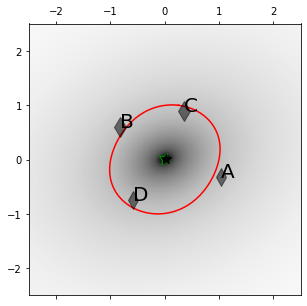

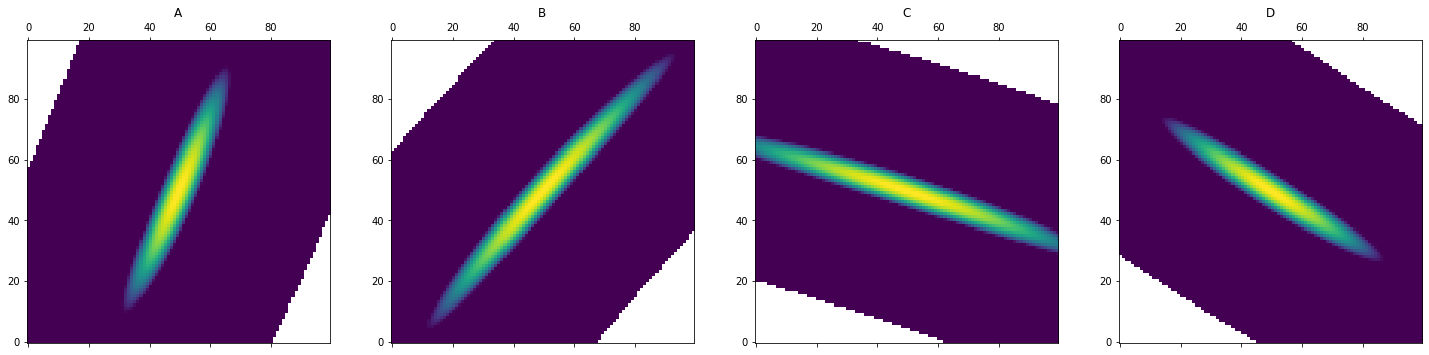

In [5]:
# the redshifts of lens and source and the cosmology is only used when predicting the relative time delays between the images
z_lens = 0.5
z_source = 1.5

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
lensCosmo = LensCosmo(cosmo=cosmo, z_lens=z_lens, z_source=z_source)


# make class instances for a chosen lens model type

# chose a lens model
lens_model_list = ['EPL', 'SHEAR']
# make instance of LensModel class
lensModel = LensModel(lens_model_list=lens_model_list, cosmo=cosmo, z_lens=z_lens, z_source=z_source)
# we require routines accessible in the LensModelExtensions class
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
# make instance of LensEquationSolver to solve the lens equation
lensEquationSolver = LensEquationSolver(lensModel=lensModel)

# make choice of lens model

# we chose a source position (in units angle) 
x_source, y_source = 0.02, 0.01
# we chose a lens model

gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.1)
kwargs_lens = [{'theta_E': 1., 'e1': 0.1, 'e2': 0.1, 'gamma': 2., 'center_x': 0, 'center_y': 0},
              {'gamma1': gamma1, 'gamma2': gamma2}]


# compute image positions and their (finite) magnifications

# we solve for the image position(s) of the provided source position and lens model
x_img, y_img = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens, sourcePos_x=x_source, 
                                                             sourcePos_y=y_source)
print('image positions are: ', x_img, y_img)
# the infinitesimal magnification at the position of the images is:
mag_inf = lensModel.magnification(x_img, y_img, kwargs_lens)
print('point source magnification: ', mag_inf)


# we chose a finite source size of the emitting 'point source' region
source_size_pc = 10. # Gaussian source size in units of parsec
# we convert the units of pc into arcseconds given the redshift of the lens and the cosmology
D_s = lensCosmo.ds
source_size_arcsec = source_size_pc / 10**6 / D_s / constants.arcsec
print('source size in arcsec: ', source_size_arcsec)

# we compute the finite magnification by rendering a grid around the point source position and add up all the flux coming from the extended source in this window
window_size = 0.1  # units of arcseconds
grid_number = 100  # supersampled window (per axis)

# and here are the finite magnifications computed
mag_finite = lensModelExtensions.magnification_finite(x_pos=x_img, y_pos=y_img, kwargs_lens=kwargs_lens, 
                                                      source_sigma=source_size_arcsec, window_size=window_size,
                                                      grid_number=grid_number)
print('finite magnification: ', mag_finite)



# here are the predicted time delays in units of days
t_days = lensModel.arrival_time(x_img, y_img, kwargs_lens)
print('time delays: ', t_days)

# here we plot the lens model, including (optional) the caustics and critical curves
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=x_source, sourcePos_y=y_source, point_source=True, with_caustics=True)
f.show()


# here we plot the finite sources as seen at the different image positions
f, axes = plt.subplots(1, len(x_img), figsize=(5*5, 5*len(x_img)), sharex=False, sharey=False)
label_list = ['A', 'B', 'C', 'D']
for i in range(len(x_img)):
    image = lensModelExtensions.zoom_source(x_pos=x_img[i], y_pos=y_img[i], kwargs_lens=kwargs_lens, 
                                                      source_sigma=source_size_arcsec, window_size=window_size,
                                                      grid_number=grid_number)
    ax = axes[i]
    ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
    ax.set_title(label_list[i])
plt.show()

## Set up data for modeling
In the previous box, we created a mock lens and computed image positions, flux ratios and time delays.
In this section, we explicitly set up the data products that we want to use for the modeling. You can replace this box with the values for the lens you want to model.

In [6]:
# the data set is taken from the mock data above (can be replaced by real data)
# image positions in relative RA (arc seconds)
ximg = x_img  # image positions in relative RA (arc seconds)
yimg = y_img  # image positions in relative DEC (arc seconds)
image_amps = np.abs(mag_inf)  # amplitudes of the images (in equivalent counts, not magnitudes)
flux_ratios = image_amps[1:] / image_amps[0]  # flux ratios relative to the first image (required by lenstronomy)
print(flux_ratios)
flux_ratio_errors = np.array([0.02, 0.02, 0.02])  # uncertainties in the flux ratios (1-sigma Gaussian error)
flux_ratios_measured = flux_ratios + np.random.normal(0, flux_ratio_errors)

astrometry_sigma = 0.005  # 1-sigma astrometric uncertainties of the image positions (assuming equal precision for all images in RA/DEC directions)

# time delays
d_dt = t_days[1:] - t_days[0]  # lenstronomy definition of relative time delay is in respect of first image in the list (full covariance is in planning)
d_dt_sigma = np.array([0.5, 0.5, 0.5])  # 1-sigma uncertainties in the time-delay measurement (in units of days)
d_dt_measured = d_dt + np.random.normal(0, d_dt_sigma)
ximg_measured = ximg + np.random.normal(0, astrometry_sigma, 4)
yimg_measured = yimg + np.random.normal(0, astrometry_sigma, 4)
# here we create a keyword list with all the data elements. If you only have partial information about your lens,
# only provide the quantities you have.
kwargs_data_joint = {'time_delays_measured': d_dt_measured,
                     'time_delays_uncertainties': d_dt_sigma,
                     'flux_ratios': flux_ratios_measured, 
                     'flux_ratio_errors': flux_ratio_errors,
                    'ra_image_list': [ximg_measured], 'dec_image_list': [yimg_measured]}


[1.3064638  1.40295285 0.91780762]


## Model settings
Here we set up the modeling (initial guess of the parameters, uncertainties and lower and upper bounds. In this example, we chose the same lens model as we produced the mock data and thus expect a perfect fit.
This part is equal to the imaging simulation of lenstronomy. We refer to other notebooks and the documentation for more details.

In [11]:
# ==================
# lens model choices
# ==================
lens_model_list = ['EPL', 'SHEAR']

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


# SPEMD parameters
fixed_lens.append({}) 
# initial parameter guess
#kwargs_lens_init.append(kwargs_lens[0])
kwargs_lens_init.append({'theta_E': 1., 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0.})
# initial particle clowd
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
# hard bound lower limit of parameters
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
# hard bound upper limit of parameters
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

# SHEAR parameters
# we keep the center of shear definition fixed at (0,0)
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
#kwargs_lens_init.append(kwargs_lens[1])
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.0})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})

# combine all parameter options for lenstronomy
lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


# =========================
# image position parameters
# =========================

# we chose to model the image positions in the lensed plane (we know where they appear)
point_source_list = ['LENSED_POSITION']
# We fix the image position coordinates.
fixed_ps = [{}]  # we fix the image position coordinates
# these lines below actually don't matter when you keep the image position fixed
kwargs_ps_init = [{'ra_image': ximg_measured, 'dec_image': yimg_measured}] # the initial guess for the appearing image positions is: at the image position.
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(ximg)), 'dec_image': 0.01 * np.ones(len(ximg))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(ximg)), 'dec_image': -10 * np.ones(len(ximg))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(ximg)), 'dec_image': 10 * np.ones(len(ximg))}]

# combine all parameter options for lenstronomy
ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]


fixed_special = {}
kwargs_special_init = {}
kwargs_special_sigma = {}
kwargs_lower_special = {}
kwargs_upper_special = {}

# =========================
# astrometric perturbations
# =========================

# astrometric perturbations are modeled in lenstronomt with 'delta_x_image' and 'delta_y_image'.
# These perturbations place the 'actual' point source at the difference to 'ra_image'.
# we let some freedome in how well the actual image positions are matching those given by the data (indicated as 'ra_image', 'dec_image' and held fixed while fitting)

#kwargs_special_init['delta_x_image'], kwargs_special_init['delta_y_image'] = np.zeros_like(ximg), np.zeros_like(yimg)
#kwargs_special_sigma['delta_x_image'], kwargs_special_sigma['delta_y_image'] = np.ones_like(ximg) * astrometry_sigma, np.ones_like(yimg) * astrometry_sigma
#kwargs_lower_special['delta_x_image'], kwargs_lower_special['delta_y_image'] = np.ones_like(ximg) * (-1), np.ones_like(yimg) * (-1)
#kwargs_upper_special['delta_x_image'], kwargs_upper_special['delta_y_image'] = np.ones_like(ximg) * (1), np.ones_like(yimg) * (1)

# ==================
# quasar source size
# ==================

# If you want to keep the source size fixed during the fitting, outcomment the line below.
fixed_special['source_size'] = source_size_arcsec
kwargs_special_init['source_size'] = source_size_arcsec
kwargs_special_sigma['source_size'] = source_size_arcsec
kwargs_lower_special['source_size'] = 0.0001
kwargs_upper_special['source_size'] = 1

# ===================
# Time-delay distance
# ===================

# with time-delay information, we can measure the time-delay distance (units physical Mpc)

# if you want to fix the cosmology and instead use the time-delay information to constrain the lens model, out-comment the line below
#fixed_special['D_dt'] = lensCosmo.D_dt
kwargs_special_init['D_dt'] = 5000
kwargs_special_sigma['D_dt'] = 3000
kwargs_lower_special['D_dt'] = 0
kwargs_upper_special['D_dt'] = 10000

special_params = [kwargs_special_init, kwargs_special_sigma, fixed_special, kwargs_lower_special, kwargs_upper_special]

# combined parameter settings
kwargs_params = {'lens_model': lens_params,
                'point_source_model': ps_params,
                'special': special_params}

# our model choices
kwargs_model = {'lens_model_list': lens_model_list, 
                'point_source_model_list': point_source_list
                 }


## setup options for likelihood and parameter sampling
In $\texttt{lenstronomy}$ the likelihood settings (which likelihood gets evaluated) and the parameter sampling options (which parameters get sampled) are separated. It is upon the user to decide the appropriate parameters to be sampled for the given choice of likelihood and information.

In [12]:
time_delay_likelihood = True  # bool, set this True or False depending on whether time-delay information is available and you want to make use of its information content.
flux_ratio_likelihood = True  # bool, modeling the flux ratios of the images
image_position_likelihood = True  # bool, evaluating the image position likelihood (in combination with astrometric errors)

kwargs_flux_compute = {'source_type': 'INF',  # you can either chose 'INF' which is a infinetesimal source sice, 'GAUSSIAN' or 'TORUS'
                       'window_size': window_size, # window size to compute the finite source magnification (only when 'GAUSSIAN' or 'TORUS' are chosen.)
                       'grid_number': grid_number}  # number of grid points (per axis) to compute the extended source surface brightness within the window_size around the image position
# ATTENTION: make sure that the numerical options are chosen to provide accurate computations for the finite source magnifications!
if kwargs_flux_compute['source_type'] in ['GAUSSIAN', 'TORUS'] and flux_ratio_likelihood is True:
    kwargs_constraints['source_size'] = True  # explicit sampling of finite source size parameter (only use when source_type='GAUSSIAN' or 'TORUS') 


kwargs_constraints = {'num_point_source_list': [len(ximg)],  
                      'Ddt_sampling': time_delay_likelihood,  # sampling of the time-delay distance                      
                     }

# we can define un-correlated Gaussian priors on specific parameters explicitly

# e.g. power-law mass slope of the main deflector
prior_lens = [[0, 'gamma', 2, 0.1], [0, 'center_x', 0, 0.01], [0, 'center_y', 0, 0.01]] # [[index_model, 'param_name', mean, 1-sigma error], [...], ...]
# e.g. source size of the emission region
prior_lens_light = []
prior_special = []
    
kwargs_likelihood = {  
                     'image_position_uncertainty': astrometry_sigma,  # astrometric uncertainty of image positions
                     'image_position_likelihood': True, # evaluate point source likelihood given the measured image positions
                     'time_delay_likelihood': time_delay_likelihood,  # evaluating the time-delay likelihood
                     'flux_ratio_likelihood': flux_ratio_likelihood,  # enables the flux ratio likelihood 
                     'kwargs_flux_compute': kwargs_flux_compute,  # source_type='INF' will lead to point source
                     'prior_lens': prior_lens,
                     'prior_lens_light': prior_lens_light,
                     'prior_special': prior_special,
                     'check_bounds': True,  # check parameter bounds and punish them
                    }


## Multiple image position constraints
Matching multiple image position constraints from the same source is a difficult and computationally tedious task. Here we discuss a few different approaches, their pros and cons and how they are implemented in lenstronomy.

1. Sampling the source position and solving the lens equation: The conceptually most straight forward approach is to sample the source position and the lens model and then compute the image positions by solving the lens equation. Apart from having the model priors well under control, this method comes with some draw-backs: (1) Solving the lens equation is computationally expensive. (2) small changes in the source position lead to significant changes in the predicted image positions in highly magnified regions and the sampling becomes inefficient. (3) the number of images appearing is not preserved and different predicted positions can not unambiguosly be matched to data points.
Lenstronomy can deal with the sampling of the source position but the image positions can not be dealt with in catalogue form but only in terms of a simulated image. This method is not recommended.

2. Sampling the image position and ray-tracing to the source position: Computationally much easier and with parameters reflecting the data much closer is chosing the image position as the sampling parameters and ray-trace back to the source plane to compute the source position. The problem: In general, the different images do not match precisely back to the same source position and the lens equation can be severely invalidated. Satisfying the lens equation is key in accurately predicting the relative time delays. Errors introduced when not matching the lens equation are discussed e.g. in Birrer & Treu 2019.
The work-around in lenstronomy: You can introduce a punishing term in the likelihood to downweight proposed models that do not meet a certain requirement in how accurately the lens equation is satisfied. In the limit of having infinite requirements on the lens equation, sampling becomes untractable. Even when the desire is having very high accuracy, sampling will lead to a non-linear degeneracy as effectively the number of sampled parameters (2x number of image positions - 2 source positions) is under-constraint. The numerical precision has to be carefully chosen to gage accuracy vs. sampling efficiency. Also: the numerical precision imposed is effectively a prior in the sampling! The numerical precision must be chosen magnification-independent to not propagate to a prior in e.g. the power-law slope inference. Lenstronomy deals with it by imposing the required source position accuracy as magnified in the image plane to avoid biases.

3. Non-linear solving of lens model parameters to satisfy the lens equation: A way to circumvene the issue of the under-constraint sampling in (2) still taking the benefit of not solving the lens equation is to constrain part of the lens model through applying a non-linear solver on the ray-tracing to match the source position. This is faster than solving the lens equation and provides an efficient sampling as the parameters are the image positions. A possible draw-back is the behaviour of the solver and the prior on these constraint model parameters are not well phrased. The advantage is that all proposed models are a solution to the lens equation to high numerical precision.

4. Fixing image position and translating astrometric uncertainties to the source plane: This is a fast and efficient method to allow for constraints on lens model parameters from multiply observed images. However the lens models that are being sampled do not satisfy the lens equation. When computing the time delays, the image positions have to be computed for the proposed lens model by solving the lens equation and at these positions the Fermat potential/time delay needs to be evaluated.

In [13]:
# setting the non-linear solver accoring to option (3)
kwargs_constraints['solver_type'] = 'NONE'  # 'PROFILE_SHEAR', 'NONE', # any proposed lens model must satisfy the image positions appearing at the position of the point sources being sampeled

# checking for matched source position in ray-tracing the image position back to the source plane.
# This flag should be set =True when dealing with option (2) and (3)
kwargs_likelihood['check_matched_source_position'] = True  # check non-linear solver and disgard non-solutions
kwargs_likelihood['source_position_tolerance'] = 0.01  # hard bound tolerance on r.m.s. scatter in the source plane to be met in the sampling

# desired precision on r.m.s. scatter in the source plane to achive. 
# This is implemented as a Gaussian likelihood term and is met when the model is sufficient in describing the data
# This precision must be set when using option (2). Option (3) should guarantee a very high precision except in some failurs of the solver.
kwargs_likelihood['source_position_sigma'] = 0.005


# setting to propagate the astrometric uncertainties in image position into a likelihood in the source position.
# Option (4) above. This option can be used SEPARATE to the solver or the source position tolerance (see below)
# Care has to be taken when requiring time-delay predictions.
kwargs_likelihood['source_position_likelihood'] = False  # evaluates how close the different image positions match the source positons]
kwargs_likelihood['image_position_uncertainty'] = astrometry_sigma  # this option (4) uses the 'image_position_uncertainty' to translate to a source position uncertainty (see also Birrer & Treu 2019)


## Run the modeling - Particle Swarm Optimization to find a maxima in the likelihood

In [14]:

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [#['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}],  # you can add additional fixed parameters if you want
                       ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 500}],]

start_time = time.time()
chain_list_pso = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
Max iteration reached! Stopping.
-2.7579540192907297 reduced X^2 of best position
-1.3789770096453648 logL
-3 effective number of data points
[{'theta_E': 1.0029405692998798, 'gamma': 1.9805349789954614, 'e1': 0.09576909211331663, 'e2': 0.09468436601179273, 'center_x': 0.004386960679790076, 'center_y': -0.004207737245664869}, {'gamma1': 0.09497046433588659, 'gamma2': 0.01922628916053006, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[] lens light result
[{'ra_image': array([ 1.03520566, -0.82626187,  0.35437418, -0.57392886]), 'dec_image': array([-0.32711997,  0.58994779,  0.89219186, -0.75837517]), 'point_amp': array([1., 1., 1., 1.])}] point source result
{'D_dt': 3474.700822898318} special param result
197.84274196624756 time used for  PSO
197.8752691745758 total tim

time-delay logL = -0.8890568064869017
flux ratio logL = -0.09471433175840757
Source scatter punishing likelihood = -0.10780870727411844
image position likelihood -0.0837004283176828
Prior likelihood = -0.20369673580825443


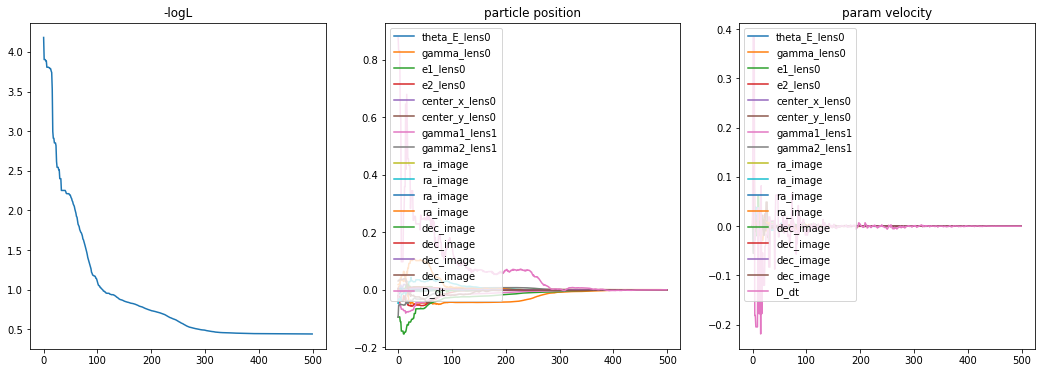

<Figure size 432x288 with 0 Axes>

In [15]:
kwargs_result = fitting_seq.best_fit(bijective=True)
args_result = fitting_seq.param_class.kwargs2args(**kwargs_result)
logL = fitting_seq.likelihoodModule.logL(args_result, verbose=True)

from lenstronomy.Plots import chain_plot
for i in range(len(chain_list_pso)):
    chain_plot.plot_chain_list(chain_list_pso, i)

## MCMC posterior sampling

In [16]:
#and now we run the MCMC
fitting_kwargs_list = [
    ['MCMC', {'n_burn': 400, 'n_run': 600, 'walkerRatio': 10,'sigma_scale': 0.1}]
]
chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

100%|██████████████████████████████████████████████| 1000/1000 [05:59<00:00,  2.78it/s]

Computing the MCMC...
Number of walkers =  170
Burn-in iterations:  400
Sampling iterations (in current run): 1000
360.0749046802521 time taken for MCMC sampling


(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

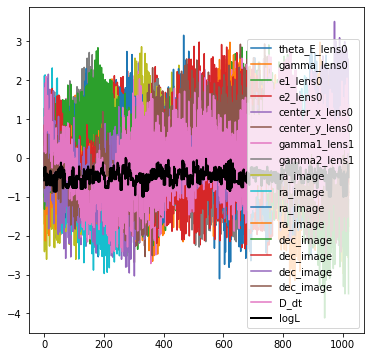

In [17]:
chain_plot.plot_chain_list(chain_list_mcmc)

## Post-processing the chains 

In [18]:

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list_mcmc[0]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])



# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
import lenstronomy.Util.param_util as param_util
# make instance of parameter class with given model options, constraints and fixed parameters
# this allows to recover the full parameters of all model components, not just the ones being sampled.

param = Param(kwargs_model, fixed_lens, kwargs_fixed_ps=fixed_ps, kwargs_fixed_special=fixed_special, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


lensModel = LensModel(kwargs_model['lens_model_list'])
lensModelExtensions = LensModelExtensions(lensModel=lensModel) 


mcmc_new_list = []
labels_new = [r"$\theta_E$", r"$\gamma$", r"$\phi_{lens}$", r"$q$", r"$\phi_{ext}$", r"$\gamma_{ext}$"]
if flux_ratio_likelihood is True:
    labels_new.extend(['B/A', 'C/A', 'D/A'])
if kwargs_constraints.get('source_size', False) is True:
    if 'source_size' not in fixed_special:
        labels_new.append('source size')
if time_delay_likelihood is True:
    labels_new.append(r"$D_{dt}$")
    
print(labels_new)


number of non-linear parameters in the MCMC process:  17
parameters in order:  ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  102000
['$\\theta_E$', '$\\gamma$', '$\\phi_{lens}$', '$q$', '$\\phi_{ext}$', '$\\gamma_{ext}$', 'B/A', 'C/A', 'D/A', '$D_{dt}$']


In [19]:
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_out = param.args2kwargs(samples_mcmc[i])
    kwargs_lens_out, kwargs_special_out, kwargs_ps_out = kwargs_out['kwargs_lens'], kwargs_out['kwargs_special'], kwargs_out['kwargs_ps']
    
    # compute 'real' image position adding potential astrometric shifts
    x_pos, y_pos = kwargs_ps_out[0]['ra_image'], kwargs_ps_out[0]['dec_image']
    
    # extract quantities of the main deflector
    theta_E = kwargs_lens_out[0]['theta_E']
    gamma = kwargs_lens_out[0]['gamma']
    e1, e2 = kwargs_lens_out[0]['e1'], kwargs_lens_out[0]['e2']
    phi, q = param_util.ellipticity2phi_q(e1, e2)
    gamma1, gamma2 = kwargs_lens_out[1]['gamma1'], kwargs_lens_out[1]['gamma2']
    phi_ext, gamma_ext = param_util.shear_cartesian2polar(gamma1, gamma2)
    new_chain = [theta_E, gamma, phi, q, phi_ext, gamma_ext]
    if flux_ratio_likelihood is True:
        mag = lensModel.magnification(x_pos, y_pos, kwargs_lens_out)
        flux_ratio_fit = mag[1:]/mag[0]
        new_chain.extend([flux_ratio_fit[0], flux_ratio_fit[1], flux_ratio_fit[2]])
    if kwargs_constraints.get('source_size', False) is True and 'source_size' not in fixed_special:
        source_size = kwargs_special_out['source_size']
        new_chain.append(source_size)
    if time_delay_likelihood is True:
        D_dt = kwargs_special_out['D_dt']
        new_chain.append(D_dt)
    
    #source_size = np.random.uniform(high=1, low=0)
    mcmc_new_list.append(np.array(new_chain))

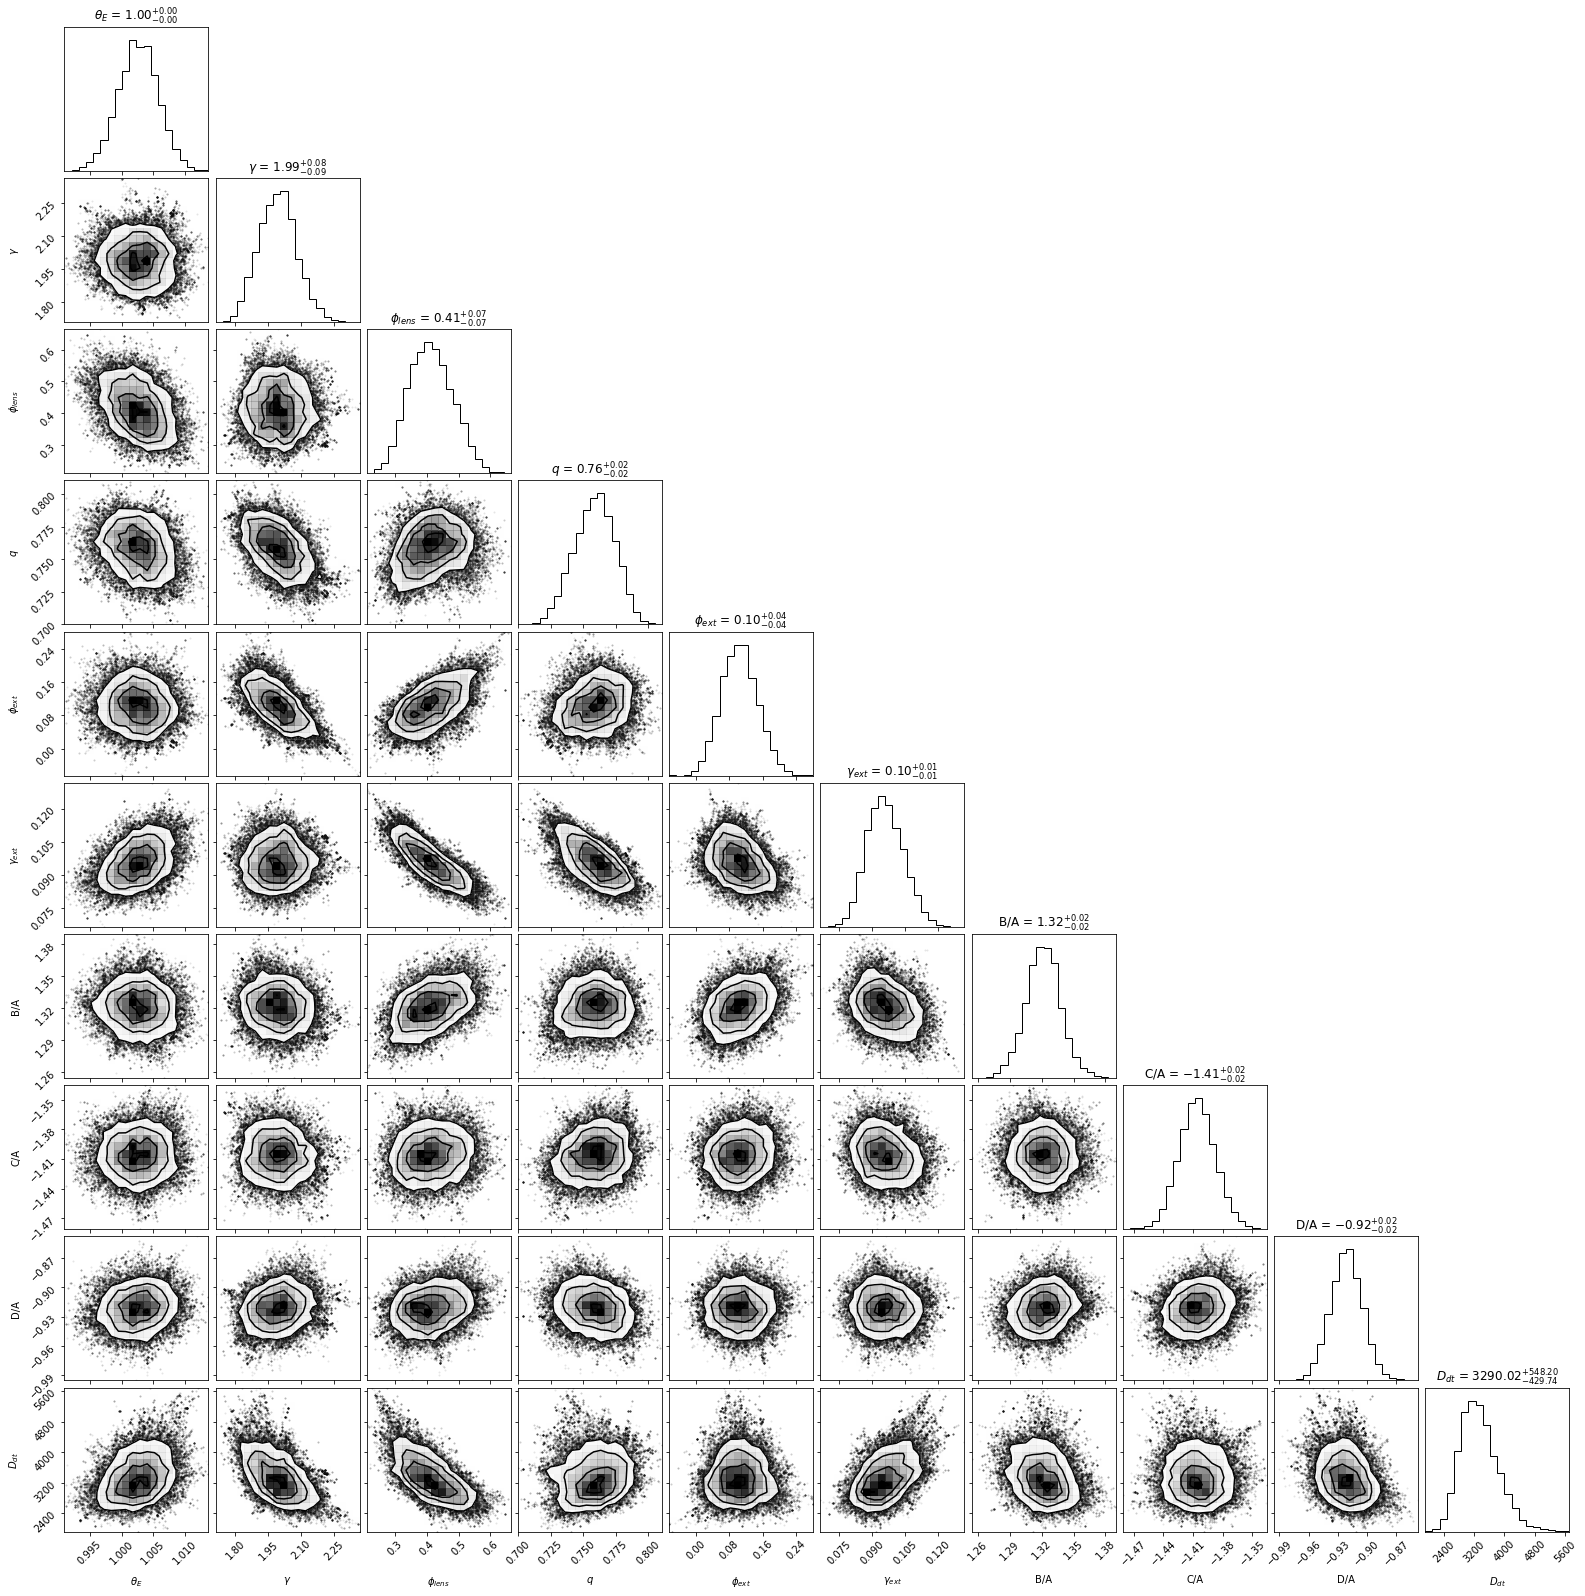

In [20]:
plot = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True)


In [21]:
# input truth time-delay distance [Mpc]
lensCosmo.ddt

3329.6653609254795